In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import datetime as dt
import os
from abc import abstractmethod

# Data preparation

In [2]:
def get_100_candles(ticker: str, tf: str, timestamp_ms_from: int):
    params = {
        'instId': ticker,
        'bar': tf,
        'after': timestamp_ms_from,
    }
    responce = requests.get('https://www.okx.com/api/v5/market/history-mark-price-candles', params)
    if not responce.ok:
        print('Bad request', responce.text)
        return
    candles = []
    for cs in json.loads(responce.text)['data']:
        candle = {
            'dt': dt.datetime.fromtimestamp(int(cs[0]) // 1000),
            'o': float(cs[1]),
            'h': float(cs[2]),
            'l': float(cs[3]),
            'c': float(cs[4]),
        }
        candles.append(candle)
    return candles

In [3]:
def get_timestamp_ms_range(from_date: dt.datetime, till_date: dt.datetime, delta: dt.timedelta):
    ts_range = []
    t = till_date
    while t > from_date:
        timestamp_ms = int(t.timestamp() * 1000)
        ts_range.append(timestamp_ms)
        t -= 100 * delta
    return ts_range

In [4]:
def get_candles_history(ticker: str, tf: str, from_date: dt.datetime, till_date: dt.datetime):
    """
    Get candlestick history of a ticker from OKX 
    """
    tf_to_timedelta = {
        '1D': dt.timedelta(days=1),
        '4H': dt.timedelta(hours=4),
    }
    candles = []
    ts_range = get_timestamp_ms_range(from_date, till_date, tf_to_timedelta[tf])
    for ts_ms in ts_range:
        new_candles = get_100_candles(ticker, tf, ts_ms)
        if new_candles:
            candles.extend(new_candles)
    if len(candles) == 0:
        return 
    df_candles = pd.DataFrame(candles).sort_values('dt')
    return df_candles[df_candles['dt'].between(from_date, till_date)].drop_duplicates('dt').reset_index(drop=True)

In [10]:
DATA_DIR = 'data'
DATA_FILENAME = 'crypto.csv'

path_to_data = os.path.join(DATA_DIR, DATA_FILENAME)
if not os.path.exists(path_to_data):
    tickers = ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT',
            'SOL-USDT', 'DOGE-TRX', 'TRX-USDT', 'LTC-USDT', 'TON-USDT',
            ]
    tf = '1D'
    date_from = dt.datetime(2020, 1, 1)
    date_till = dt.datetime(2025, 4, 1)
    data = []
    for ticker in tickers:
        print(ticker)
        ret = get_candles_history(ticker, tf, date_from, date_till)
        if ret is not None:
            ts = pd.Series(data=ret['c'].values, index=ret['dt'], name=ticker)
            data.append(ts)
    data = pd.concat(data, axis=1)
    data.to_csv(path_to_data)

data = pd.read_csv(path_to_data, index_col='dt', parse_dates=['dt'])
data.dropna(inplace=True)
data.sort_index(inplace=True)
print(data.shape)

(736, 9)


In [11]:
np.argmin(data.isna().sum(axis=1))

np.int64(0)

In [12]:
N = data.shape[1]
ASSET_NAMES = data.columns.tolist()

print('observations', data.shape[0])
print('from', data.index.min())
print('till', data.index.max())
print('ccys', ASSET_NAMES)

observations 736
from 2022-12-27 19:00:00
till 2024-12-31 19:00:00
ccys ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT', 'SOL-USDT', 'TRX-USDT', 'LTC-USDT', 'TON-USDT']


In [ ]:
ret = data.diff(7) / data.shift(7)
ret.dropna(inplace=True)
ret

,BTC-USDT,ETH-USDT,DOT-USDT,OKB-USDT,XRP-USDT,SOL-USDT,TRX-USDT,LTC-USDT,TON-USDT
dt,,,,,,,,,
2023-01-03 19:00:00,0.016653,0.055943,0.078490,0.174594,-0.026963,0.344460,0.017953,0.131493,0.083537
2023-01-04 19:00:00,0.013683,0.040196,0.055594,0.117705,-0.017099,0.417093,-0.009193,0.110464,0.040553
2023-01-05 19:00:00,0.017247,0.056698,0.088304,0.069087,-0.005211,0.377898,-0.036374,0.109112,0.034217
2023-01-06 19:00:00,0.020868,0.051423,0.067781,0.027579,0.002587,0.306488,-0.050605,0.083607,-0.013309
2023-01-07 19:00:00,0.026649,0.064812,0.095183,-0.020894,0.018316,0.406570,-0.034835,0.090702,-0.049956
...,...,...,...,...,...,...,...,...,...
2024-12-27 19:00:00,-0.031560,-0.006595,-0.024435,0.189876,-0.037772,0.018749,0.043164,-0.009336,0.081324
2024-12-28 19:00:00,-0.009079,0.021703,0.013931,0.110027,-0.024780,0.073090,0.067253,0.001392,0.063357
2024-12-29 19:00:00,-0.012196,0.014207,-0.036427,0.101556,-0.055569,0.035434,0.014137,-0.013042,0.019852


# Mean-Varince estimates
## Covariance estimate

In [9]:
cov_hat = ret.cov()
cov_hat

,BTC-USDT,ETH-USDT,DOT-USDT,OKB-USDT,XRP-USDT,SOL-USDT,TRX-USDT,LTC-USDT,TON-USDT
BTC-USDT,0.005208,0.004586,0.005188,0.003504,0.004218,0.006346,0.001606,0.004045,0.002343
ETH-USDT,0.004586,0.006314,0.006413,0.004150,0.004552,0.006349,0.001904,0.004783,0.002337
DOT-USDT,0.005188,0.006413,0.012187,0.005960,0.008293,0.010149,0.003851,0.006667,0.003721
OKB-USDT,0.003504,0.004150,0.005960,0.007174,0.003618,0.005738,0.002152,0.004049,0.003502
XRP-USDT,0.004218,0.004552,0.008293,0.003618,0.019983,0.006634,0.004998,0.007284,0.003062
SOL-USDT,0.006346,0.006349,0.010149,0.005738,0.006634,0.019219,0.002574,0.006135,0.003699
TRX-USDT,0.001606,0.001904,0.003851,0.002152,0.004998,0.002574,0.005802,0.003665,0.000993
LTC-USDT,0.004045,0.004783,0.006667,0.004049,0.007284,0.006135,0.003665,0.008428,0.002980
TON-USDT,0.002343,0.002337,0.003721,0.003502,0.003062,0.003699,0.000993,0.002980,0.011423


In [21]:
def estimate_cov(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.cov()
    if isinstance(ret, np.ndarray):
        return np.cov(ret, rowvar=False)

## Mean estimate 1: Dummmy

In [22]:
def estimate_mean_dummy(ret):
    return ret.mean(axis=0)

## Mean estimate 2: Martingal

In [23]:
def estimate_mean_martingal(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.iloc[-1]
    if isinstance(ret, np.ndarray):
        return ret[-1, :]

## Mean estimate 3: Time Series approach

In [24]:
def estimate_mean_ts(ret):
    pass

In [ ]:
# class MuEstimator:
#     def __str__(self):
#         return f'{self.name}'
#     def __repr__(self):
#         return self.__str__()

# class MuDummyEstimator(MuEstimator):
#     name = 'dummy'
#     def __call__(self, ret):
#         return ret.mean(axis=0)
    
# class MuMartingalEstimator(MuEstimator):
#     name = 'martingal'
#     def __call__(ret):
#         if isinstance(ret, pd.DataFrame):
#             return ret.iloc[-1]
#         if isinstance(ret, np.ndarray):
#             return ret[-1, :]
# class MuTsEstimator(MuEstimator):
#     pass

# Building portfolio

## Today frontier

In [25]:
def min_var_fixed_mean(mu_hat, cov_hat, expected_return):
    n = mu_hat.shape[0]

    def objective(x):
        x = x.reshape((-1, 1))
        return x.T @ cov_hat @ x

    def unit_portfolio(x):
        return np.abs(x).sum() - 1
    
    def minimal_return(x):
        x = x.reshape((-1, 1))
        return x.T @ mu_hat - expected_return
    
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    uneq_cons = {
        'type': 'ineq',
        'fun': minimal_return,
    }

    bounds = [(-1, 1) for i in range(n)]
    x0 = np.ones(n) / n

    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons, uneq_cons]
    )
    return sol.x.reshape((-1, 1)), sol

In [26]:
def build_frontier(mu_hat, cov_hat, mean_roi_range):
    mean_roi = []
    var_roi = []
    for t in mean_roi_range:
        w, meta = min_var_fixed_mean(mu_hat, cov_hat, t)
        if not meta.success:
            continue
        mean_roi.append((w.T @ mu_hat).item())
        var_roi.append((w.T @ cov_hat.values @ w).item())
    order = np.argsort(mean_roi)
    return np.array(var_roi)[order], np.array(mean_roi)[order]

Text(0, 0.5, 'Mean ROI')

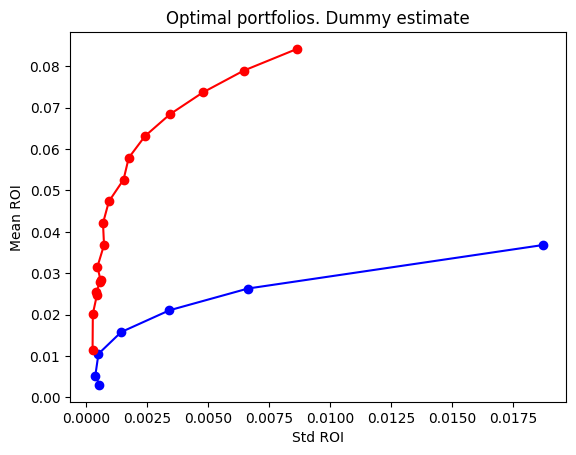

In [27]:
mean_roi_range = np.linspace(0, 0.1, 20)
cov_hat = estimate_cov(ret)

mu_hat = estimate_mean_dummy(ret)
roi_var, roi_mean = build_frontier(mu_hat, cov_hat, mean_roi_range)
plt.plot(roi_var, roi_mean, marker='o', c='blue')

mu_hat = estimate_mean_martingal(ret)
roi_var, roi_mean = build_frontier(mu_hat, cov_hat, mean_roi_range)
plt.plot(roi_var, roi_mean, marker='o', c='red')

plt.title('Optimal portfolios. Dummy estimate')
plt.xlabel('Std ROI')
plt.ylabel('Mean ROI')

# Backtesting strategies

In [28]:
def timeseries_split(df:pd.DataFrame, input_width:int, offset:int):
    size = df.shape[0]
    total_width = input_width + offset
    for i in range(size - total_width):
        x_hist = df.iloc[:i+input_width].values
        x_future = df.iloc[i + total_width].values.reshape((1, -1))
        yield i, x_hist, x_future

In [29]:
class Strategy:
    @abstractmethod
    def fit(self, x_hist):
        pass
    def predict(self, x_hist):
        return self._w
    def to_dict(self):
        return self.__dict__

class SingleAsset(Strategy):
    def __init__(self, idx):
        self.idx = idx
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        self._w = np.zeros((self._n, 1))
        self._w[self.idx] = 1

class Markowitz(Strategy):
    def __init__(self, minimal_return, mu_estimator, max_history_leng=None):
        self.minimal_return = minimal_return
        self.mu_estimator = mu_estimator
        self.max_history_leng = max_history_leng
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        if self.max_history_leng is not None:
            x_hist = x_hist[-self.max_history_leng:, :]
        cov_hat = estimate_cov(x_hist)
        mu_hat = self.mu_estimator(x_hist)
        w, sol = min_var_fixed_mean(mu_hat, cov_hat, self.minimal_return)
        if sol.success:
            self._w = w.reshape((-1, 1))
            return 
        self._w = np.zeros((self._n, 1))
    def __str__(self):
        return f'Markowitz({self.__dict__})'
    def __repr__(self):
        return self.__str__()

In [83]:
mu_estimator_map = {
    'dummy': estimate_mean_dummy,
    'martingal': estimate_mean_martingal,
}

param_grid = []
strategies = []

for mu_est in ['dummy']:#, 'martingal']:
    for min_ret in np.linspace(0.01, 0.1, 10):
        min_ret = float(min_ret)
        for mhl in list(np.arange(10, 50, 5)) + [None]:
            if mhl:
                mhl = int(mhl)
            params = dict(
                    minimal_return=min_ret,
                    mu_estimator=mu_est,
                    max_history_leng=mhl,
                )
            param_grid.append(params)
            strategies.append(
                  Markowitz(
                    minimal_return=params['minimal_return'],
                    mu_estimator=mu_estimator_map[params['mu_estimator']],
                    max_history_leng=params['max_history_leng'],
                )
            )
with open('functional_cache/param_grid.json', 'w') as f:
    f.write(json.dumps(param_grid, indent=4))

results = [[] for s in strategies]
offset = 7
input_width = 10
val_data = ret.tail(20)

print(f'Number of Strategies: {len(strategies)}')
total_tests = val_data.shape[0] - offset - input_width
print(f'Number of splits: {total_tests}')

for i, x_hist, x_future in timeseries_split(val_data, input_width, offset):
    if i > 100:
        break
    print(f'{i: <3}/{total_tests} - {dt.datetime.now()} ')
    for j, strategy in enumerate(strategies):
        try:
            strategy.fit(x_hist)
        except Exception as e:
            print(f'{i}\n', e)
            continue
        w_pred = strategy.predict(x_hist)
        roi = (x_future @ w_pred).item()
        results[j].append(roi)
results = pd.DataFrame(results).T
report = pd.concat([pd.DataFrame(param_grid).T, results.describe()], axis=0).T
report

Number of Strategies: 90
Number of splits: 3
0  /3 - 2025-03-31 17:50:16.298213 
1  /3 - 2025-03-31 17:50:17.934835 
2  /3 - 2025-03-31 17:50:20.069966 


,minimal_return,mu_estimator,max_history_leng,count,mean,std,min,25%,50%,75%,max
0,0.01,dummy,10.0,3.0,-0.002671,0.010627,-0.012894,-0.008167,-0.00344,0.00244,0.00832
1,0.01,dummy,15.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
2,0.01,dummy,20.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
3,0.01,dummy,25.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
4,0.01,dummy,30.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
...,...,...,...,...,...,...,...,...,...,...,...
85,0.1,dummy,30.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
86,0.1,dummy,35.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
87,0.1,dummy,40.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
88,0.1,dummy,45.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843


In [79]:
results.describe()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,-0.002671,-0.003129,-0.003129,-0.003129,-0.003129,-0.003129,-0.003129,-0.003129,-0.003129,-0.002531,...,0.024338,0.012113,0.037005,0.037005,0.037005,0.037005,0.037005,0.037005,0.037005,0.037005
std,0.010627,0.010785,0.010785,0.010785,0.010785,0.010785,0.010785,0.010785,0.010785,0.010722,...,0.015920,0.001070,0.023117,0.023117,0.023117,0.023117,0.023117,0.023117,0.023117,0.023117
min,-0.012894,-0.012894,-0.012894,-0.012894,-0.012894,-0.012894,-0.012894,-0.012894,-0.012894,-0.012318,...,0.005958,0.011379,0.011619,0.011619,0.011619,0.011619,0.011619,0.011619,0.011619,0.011619
25%,-0.008167,-0.008918,-0.008918,-0.008918,-0.008918,-0.008918,-0.008918,-0.008918,-0.008918,-0.008261,...,0.019625,0.011499,0.027086,0.027086,0.027086,0.027086,0.027086,0.027086,0.027086,0.027086
50%,-0.003440,-0.004942,-0.004942,-0.004942,-0.004942,-0.004942,-0.004942,-0.004942,-0.004942,-0.004204,...,0.033292,0.011619,0.042553,0.042553,0.042553,0.042553,0.042553,0.042553,0.042553,0.042553
75%,0.002440,0.001753,0.001753,0.001753,0.001753,0.001753,0.001753,0.001753,0.001753,0.002363,...,0.033529,0.012480,0.049698,0.049698,0.049698,0.049698,0.049698,0.049698,0.049698,0.049698
max,0.008320,0.008447,0.008447,0.008447,0.008447,0.008447,0.008447,0.008447,0.008447,0.008930,...,0.033766,0.013341,0.056843,0.056843,0.056843,0.056843,0.056843,0.056843,0.056843,0.056843


,minimal_return,mu_estimator,max_history_leng,count,mean,std,min,25%,50%,75%,max
0,0.01,dummy,10.0,3.0,-0.002671,0.010627,-0.012894,-0.008167,-0.00344,0.00244,0.00832
1,0.01,dummy,15.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
2,0.01,dummy,20.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
3,0.01,dummy,25.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
4,0.01,dummy,30.0,3.0,-0.003129,0.010785,-0.012894,-0.008918,-0.004942,0.001753,0.008447
...,...,...,...,...,...,...,...,...,...,...,...
85,0.1,dummy,30.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
86,0.1,dummy,35.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
87,0.1,dummy,40.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843
88,0.1,dummy,45.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843


In [81]:
tau = 1
report.assign(ord=report['mean'] - tau * report['std']).sort_values('ord', ascending=False)

,minimal_return,mu_estimator,max_history_leng,count,mean,std,min,25%,50%,75%,max,ord
89,0.1,dummy,NaN,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843,0.013888
88,0.1,dummy,45.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843,0.013888
87,0.1,dummy,40.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843,0.013888
86,0.1,dummy,35.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843,0.013888
85,0.1,dummy,30.0,3.0,0.037005,0.023117,0.011619,0.027086,0.042553,0.049698,0.056843,0.013888
...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.08,dummy,25.0,3.0,0.005668,0.025357,-0.023355,-0.003263,0.01683,0.020179,0.023529,-0.019689
65,0.08,dummy,20.0,3.0,0.005668,0.025357,-0.023355,-0.003263,0.01683,0.020179,0.023529,-0.019689
64,0.08,dummy,15.0,3.0,0.005668,0.025357,-0.023355,-0.003263,0.01683,0.020179,0.023529,-0.019689
68,0.08,dummy,35.0,3.0,0.005668,0.025357,-0.023355,-0.003263,0.01683,0.020179,0.023529,-0.019689


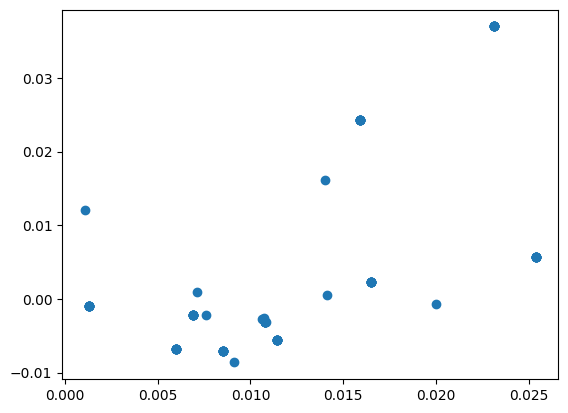

In [82]:
plt.scatter(report['std'], report['mean'])

In [45]:
mask = np.argwhere([x['mu_estimator'] == 'dummy' for x in param_grid]).flatten()
test_result[mask]

KeyError: '[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379] not in index'

### Зависимость доходности от параметров стратегии

Number of Strategies: 10


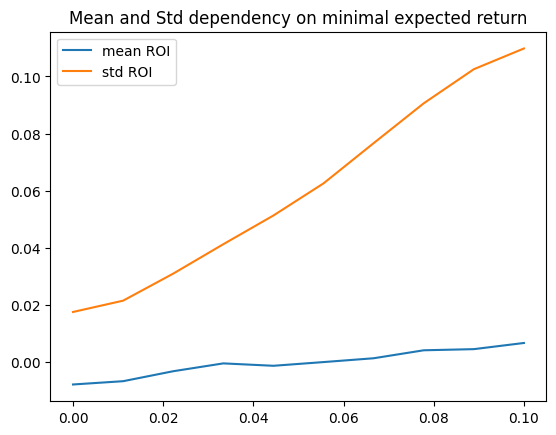

In [384]:
t_range = np.linspace(0, 0.1, 10)
strats = [Markowitz(t, estimate_mean_dummy) for t in t_range]
stats = test_strategies(strats, ret).describe().T

plt.plot(t_range, stats['mean'], label='mean ROI')
plt.plot(t_range, stats['std'], label='std ROI')
plt.title('Mean and Std dependency on minimal expected return')
plt.legend()
plt.show()

Number of Strategies: 8


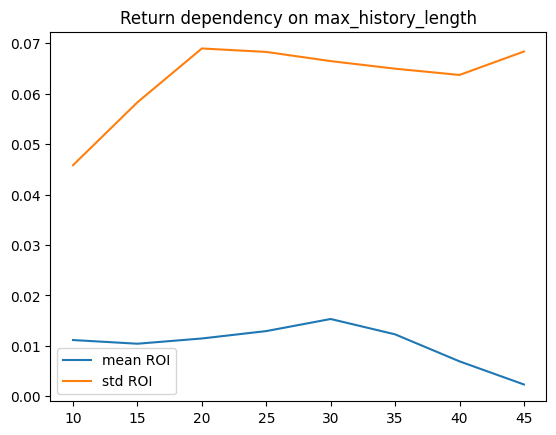

In [363]:
t_range = np.arange(10, 50, 5)
strats = [Markowitz(t, 0.06, estimate_mean_dummy, t) for t in t_range]
stats = test_strategies(strats, ret).describe().T

plt.plot(t_range, stats['mean'], label='mean ROI')
plt.plot(t_range, stats['std'], label='std ROI')
plt.title('Return dependency on max_history_length')
plt.legend()
plt.show()

In [ ]:
param_grid = []
for 

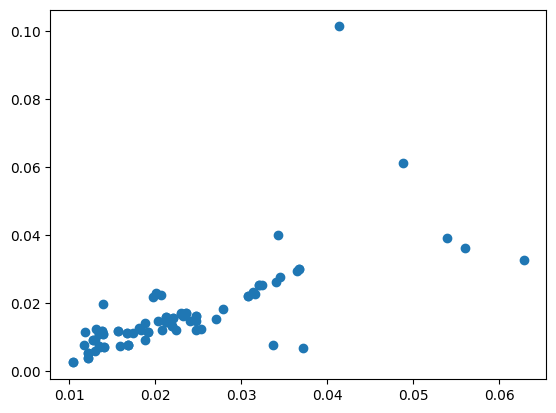

In [330]:
plt.scatter(rois_aggregated['std'], rois_aggregated['mean'])

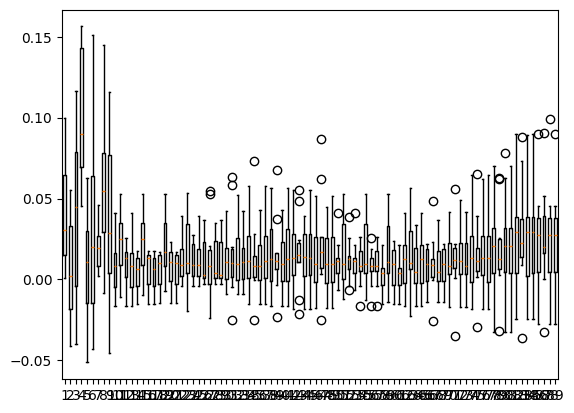

In [331]:
plt.boxplot(rois)
plt.show()